# Opening a SNiPER userfile

In [1]:
import orsa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

sns.set(style = 'white')
mpl.rc('xtick.minor', visible = True)
mpl.rc('ytick.minor', visible = True)
mpl.rc('xtick', direction='in', top=True, bottom = True)
mpl.rc('ytick', direction='in', right=True, left = True)

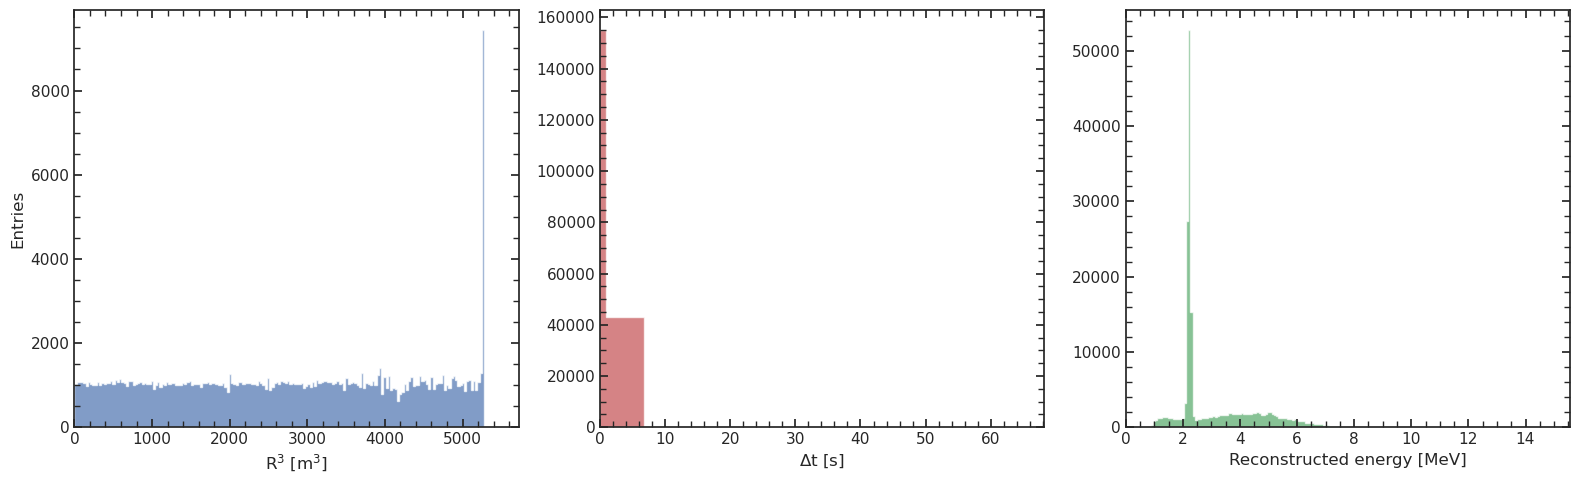

In [2]:
reco = orsa.sniper.load_userfile('inputs/reactor_userfile.root').to_list()

reco

In [3]:
promptlist, delayedlist = orsa.selection.standard(reco)

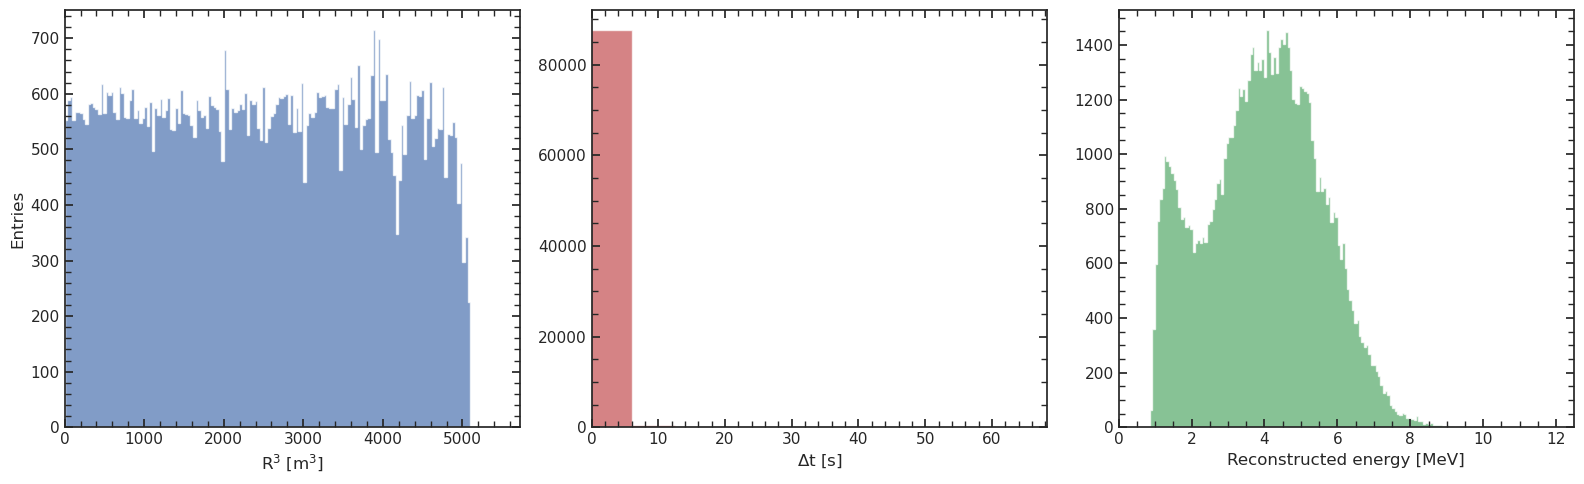

In [4]:
promptlist

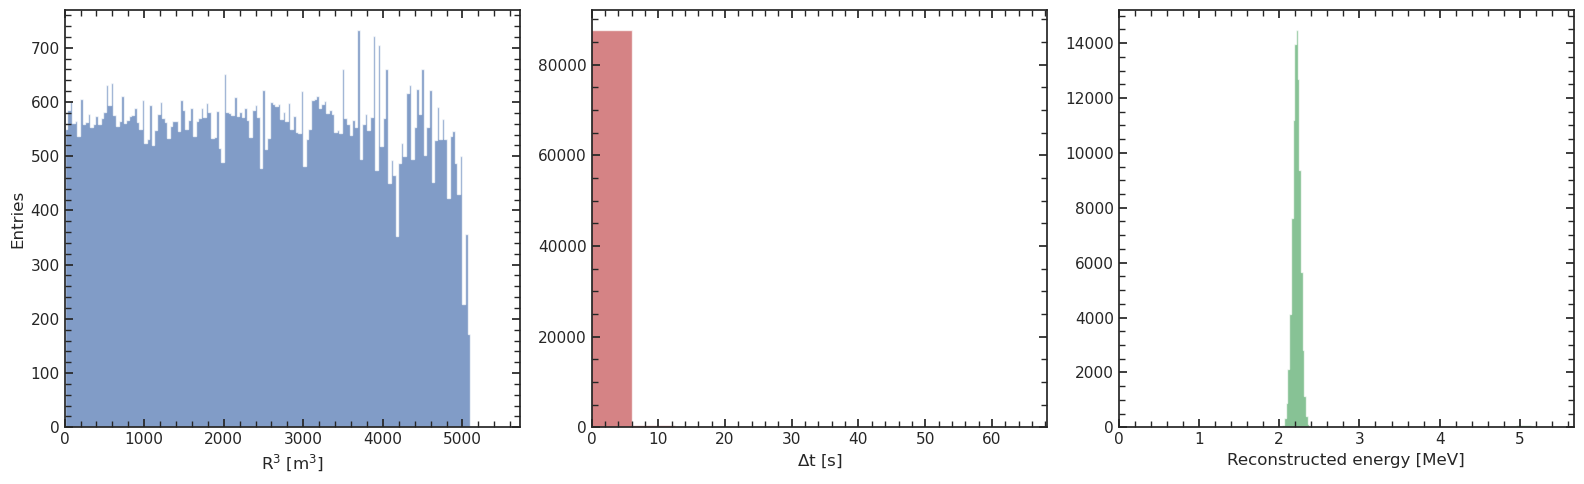

In [5]:
delayedlist

## Let's try a fit

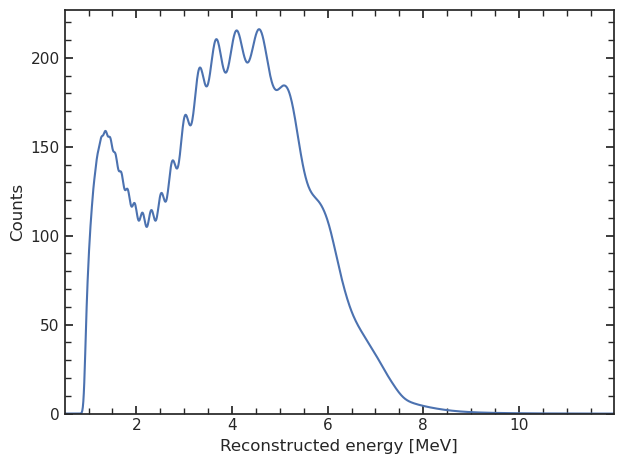

In [6]:
model = orsa.model.Model(parameters = [], E_eval = np.arange(0.5, 12, 0.01), E_fit_min=0.8, E_fit_max=11, oscillation=orsa.oscillation.load(), detector=orsa.detector.load(), use_gpu=False, use_shape_uncertainty=True, rebin = 1, exposure = 1)

model.add_parameter(orsa.model.DetectorParameter(label = 'eff', value = 1,          error = 0.01,   prior = {'positive': None},   formatted_label = r'$\epsilon$'))
model.add_parameter(orsa.model.ResolutionParameter(label = 'a',   value = 0.02614,    error = 0.0077, prior = {'positive': None},   formatted_label = r'$a$'))
model.add_parameter(orsa.model.ResolutionParameter(label = 'b',   value = 0.006401,   error = 0.012,  prior = {'positive': None},   formatted_label = r'$b$'))
model.add_parameter(orsa.model.ResolutionParameter(label = 'c',   value = 0.01205,    error = 0.033,  prior = {'positive': None},   formatted_label = r'$c$'))
model.add_parameter(orsa.model.NonLinearityParameter(label = 'a0',  value = 0,          error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_0$'))
model.add_parameter(orsa.model.NonLinearityParameter(label = 'a1',  value = 0,          error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_1$'))
model.add_parameter(orsa.model.NonLinearityParameter(label = 'a2',  value = 0,          error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_2$'))
model.add_parameter(orsa.model.NonLinearityParameter(label = 'a3',  value = 0,          error = 1,      is_relative=False,            formatted_label = r'$a^{nl}_3$'))

model.add_parameter(orsa.model.OscillationParameter(label = 'rho',      value = 2.45,       error = 0.06,   prior = {'positive': None}, formatted_label = r'$\rho$'))
model.add_parameter(orsa.model.OscillationParameter(label = 'dm2_21',   value = 7.53e-5,    error = np.inf,                       formatted_label = r'$\Delta m^2_{21}$'))
model.add_parameter(orsa.model.OscillationParameter(label = 'dm2_31',   value = 2.5283e-3,  error = np.inf,                       formatted_label = r'$\Delta m^2_{31}$'))
model.add_parameter(orsa.model.OscillationParameter(label = 's2_12',    value = 0.307,      error = np.inf,                       formatted_label = r'$\sin^2 \theta_{12}$'))
model.add_parameter(orsa.model.OscillationParameter(label = 's2_13',    value = 0.0218,     error = np.inf,                       formatted_label = r'$\sin^2 \theta_{13}$'))

# norm_scale = 6*365.25 # 6 years
shape_fact = np.sqrt(36e-03/model.bin)
shape_fact_20 = np.sqrt(20e-03/model.bin)

gen_dict = dict()
gen_dict['rea'] = orsa.generator.reactor('HM_bump', isPDF=True, xs=model.detector.crosssection, shape_uncertainty='tao')
model.add_parameter(orsa.model.CoreParameter(label = 'YJ-C1', value = 1, error = 0.008, formatted_label = r'$R_\mathrm{YJ-C1}$', baseline = 52.74, power = 2.9))
model.add_parameter(orsa.model.NormalizationParameter(label = 'rea',   value = promptlist.n,    generator = gen_dict['rea'],     error = 0.02,     is_oscillated=True, has_duty=False,      formatted_label = r'$N_\mathrm{rea}$'))

asimov = model.get_spectrum(asimov = True).to_hist()
asimov

In [7]:
data_hist = promptlist.to_hist(asimov.Eedges)
init_model = model.copy()
model.use_shape_uncertainty = False
cf = orsa.probability.CostFunction(ll=orsa.probability.chi2, model=model, data=data_hist, ll_args = dict(which = 'C'))
res = orsa.fit.minuit(cf)

Cost function parsed as chi2-like


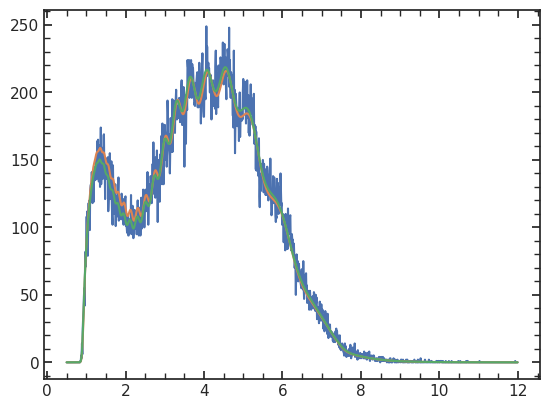

In [8]:
sp0 = init_model.get_spectrum(asimov=True)
sp1 = model.get_spectrum(asimov=True)

plt.plot(data_hist.E, data_hist.counts)
plt.plot(sp0.E, sp0.counts)
plt.plot(sp1.E, sp1.counts)

(0.0, 280.0)

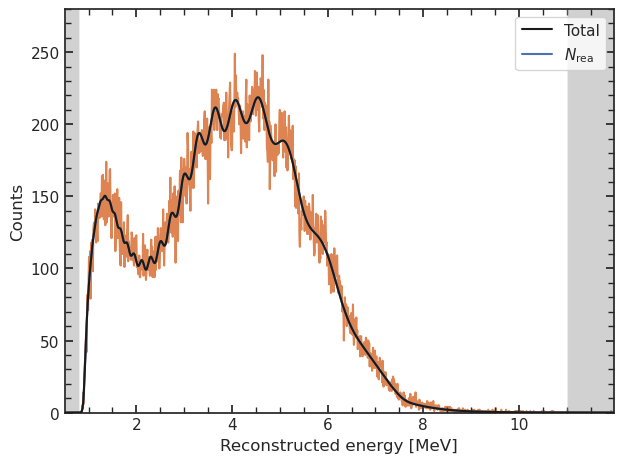

In [9]:
fig, ax = model.get_fig()
ax.plot(data_hist.E, data_hist.counts, zorder = -10)
ax.set_ylim(top = 280)

In [10]:
res.obj

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 4184                       │              Nfcn = 664              │
│ EDM = 1.36e-06 (Goal: 0.0002)    │            time = 2.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ eff:    │   1.000   │   0.009   │            │            │         │         │       │
│ 1 │ a:      │ 26.16e-3  │  0.20e-3  │            │            │         │         │       │
│ 2 │ b:      │  6.40e-3  │  0.08e-3  │            │            │         │         │       │
│ 3 │ c:      │  12.1e-3  │  0.4e-3   │            │            │         │         │       │
│ 4 │ a0:     │    0.7    │    0.9    │            │            │         │         │       │
│ 5 │ a1:     │   -0.2    │    0.7    │            │            │         │         │       │
│ 6 │ a2:     │    0.1    │    0.6    │            │            │         │         │       │
│ 7 │ a3:     │   -0.9    │    0.7    │            │            │         │         │       │
│ 8 │ rho:    │   2.45    │   0.15    │            │            │         │         │       │
│ 9 │ dm2_21: │ 74.42e-6  │  0.12e-6  │            │            │         │         │       │
│ 10│ dm2_31: │ 2.517e-3  │ 0.004e-3  │            │            │         │         │       │
│ 11│ s2_12:  │  0.3123   │  0.0013   │            │            │         │         │       │
│ 12│ s2_13:  │  0.0196   │  0.0022   │            │            │         │         │       │
│ 13│ YJ-C1:  │   1.000   │   0.008   │            │            │         │         │       │
│ 14│ rea:    │  278.8e3  │   3.3e3   │            │            │         │         │       │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│         │            eff:              a:              b:              c:             a0:             a1:             a2:             a3:            rho:         dm2_21:         dm2_31:          s2_12:          s2_13:          YJ-C1:            rea: │
├─────────┼─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│    eff: │         8.4e-05         0.01e-6            1e-9         0.01e-6         0.05e-3         0.06e-3         0.36e-3        -0.14e-3               0      42.503e-12        0.197e-9          1.2e-6            2e-6        -0.01e-3       -17.83858 │
│      a: │         0.01e-6        4.04e-08           -0e-9              -0        -0.13e-6        -0.52e-6        -0.58e-6         3.13e-6              -0      -0.057e-12       -0.004e-9               0         0.02e-6               0      8.08367e-3 │
│      b: │            1e-9     

/home/ubuntu/miniconda3/lib/python3.11/site-packages/orsa/fit/minimizers.py:152: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = np.random.multivariate_normal(
  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:05<00:00, 195.12it/s]


(<Figure size 800x600 with 1 Axes>, <Axes: >)

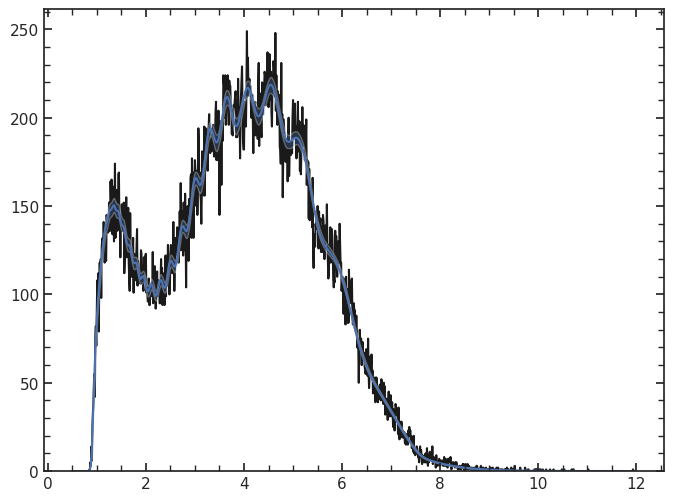

In [11]:
res.get_samples(10000)

orsa.plot.plot_ci(res, 1000, [3]) # Needs fix

In [12]:
cf_unb = orsa.probability.CostFunction(ll=orsa.probability.ll_unbinned, model = model, data=promptlist, ll_args=dict())

cf_unb.lp_args = cf_unb.lp_args

res_unb = orsa.fit.minuit(cf_unb)

Cost function parsed as LogLikelihood-like


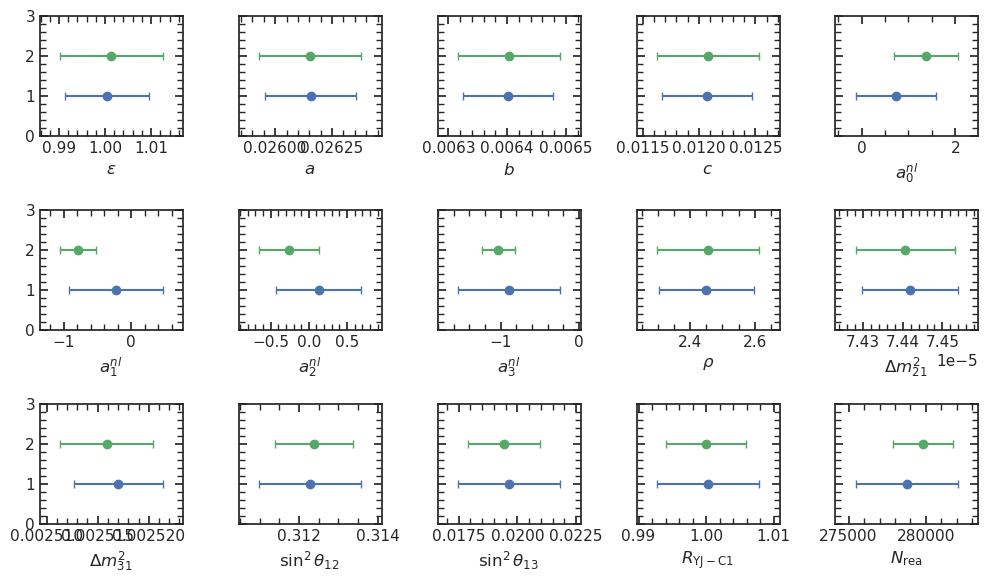

In [13]:
orsa.plot.bars([res, res_unb], true_values=False);